In [1]:
# Checking Python's version
!python -V

Python 3.9.16


In [2]:
# Importing libraries

import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import (auc,
                             confusion_matrix,
                             classification_report, 
                             precision_recall_curve)
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

# Import and Data Checks

In [3]:
# import training dataset
train_data = pd.read_csv('../data/training_features.csv')
y_train = pd.read_csv('../data/training_targets.csv')

In [4]:
# Check training data info  
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1904 entries, 0 to 1903
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   1904 non-null   int64  
 1   Year_Birth           1904 non-null   int64  
 2   Education            1904 non-null   object 
 3   Marital_Status       1904 non-null   object 
 4   Income               1885 non-null   float64
 5   Kidhome              1904 non-null   int64  
 6   Teenhome             1904 non-null   int64  
 7   Dt_Customer          1904 non-null   object 
 8   Recency              1904 non-null   int64  
 9   MntWines             1904 non-null   int64  
 10  MntFruits            1904 non-null   int64  
 11  MntMeatProducts      1904 non-null   int64  
 12  MntFishProducts      1904 non-null   int64  
 13  MntSweetProducts     1904 non-null   int64  
 14  MntGoldProds         1904 non-null   int64  
 15  NumDealsPurchases    1904 non-null   i

In [5]:
# overview of the data
train_data.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain
0,7129,1962,PhD,Married,54693.0,0,1,2013-02-17,72,686,...,6,4,13,6,0,0,0,0,0,0
1,4345,1964,2n Cycle,Single,NaN,1,1,2014-01-12,49,5,...,1,0,2,7,0,0,0,0,0,0
2,4047,1954,PhD,Married,65324.0,0,1,2014-01-11,0,384,...,6,2,9,4,0,0,0,0,0,0
3,1584,1977,Graduation,Married,41443.0,1,0,2014-04-01,79,171,...,8,1,5,8,0,0,0,0,0,0
4,7093,1985,Graduation,Married,19986.0,1,0,2013-11-14,74,3,...,0,0,3,7,0,0,0,0,0,0


In [6]:
# check for missing values
train_data.isna().sum()[train_data.isna().sum() > 0]

Income    19
dtype: int64

In [7]:
# Check feature diversity
train_data.nunique().to_frame().T

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain
0,1904,59,5,8,1715,3,3,649,100,723,...,15,14,14,15,2,2,2,2,2,2


In [8]:
# check for class imbalance
y_train.value_counts(normalize=True)

Response
0           0.858193
1           0.141807
dtype: float64

# Pre-Processing

In [9]:
# Conversions into 'datetime' data type
train_data['Year_Birth'] = pd.to_datetime(train_data['Year_Birth'], format='%Y')
train_data["Dt_Customer"] = pd.to_datetime(train_data["Dt_Customer"])

In [10]:
# get customer age
# assuming analysis was conducted in 2014
now = 2014
train_data['Age'] = now - train_data['Year_Birth'].dt.year

In [11]:
# define the bin edges for age groups
bins = [18, 28, 38, 48, 58, 65, np.inf]

# define the labels for each age group
labels = ['18-27', '28-37', '38-47', '48-57', '58-65', '65+']

# create the age groups column
train_data['Age_Group'] = pd.cut(train_data['Age'], bins=bins, labels=labels, right=False)
train_data['Age_Group'].unique()

['48-57', '58-65', '28-37', '65+', '38-47', '18-27']
Categories (6, object): ['18-27' < '28-37' < '38-47' < '48-57' < '58-65' < '65+']

In [12]:
# get the number of days since customer enrolled
end_fiscal = datetime(2014, 6, 30)
train_data['Onboard_Days'] = (end_fiscal - train_data['Dt_Customer']).dt.days

In [13]:
# calculate overall spending
train_data['Spending'] = (train_data['MntWines'] + train_data['MntFruits'] + train_data['MntMeatProducts'] + 
                  train_data['MntFishProducts'] + train_data['MntSweetProducts'] + train_data['MntGoldProds'])

In [14]:
# reduce categories in marital status
marital_status = {'Divorced': 'Alone', 'Single': 'Alone', 'Married': 'In couple', 'Together': 'In couple', 'Absurd': 'Alone', 'Widow': 'Alone', 'YOLO': 'Alone'}
train_data['Marital_Status'] = train_data['Marital_Status'].replace(marital_status)

In [15]:
# reduce categories in education
education_level = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate', 'Graduation': 'Postgraduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
train_data['Education'] = train_data['Education'].replace(education_level)

In [16]:
# get the count of children
train_data['Children'] = train_data['Kidhome'] + train_data['Teenhome']

In [17]:
# drop redundant features
redundant_features = ['Year_Birth', 'Dt_Customer', 'Age', 'ID', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Kidhome', 'Teenhome']
train_data = train_data.drop(redundant_features, axis=1)

In [18]:
# glimpse of the data
train_data.head()

,Education,Marital_Status,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Age_Group,Onboard_Days,Spending,Children
0,Postgraduate,In couple,54693.0,72,8,6,4,13,6,0,0,0,0,0,0,48-57,498,929,1
1,Undergraduate,Alone,NaN,49,1,1,0,2,7,0,0,0,0,0,0,48-57,169,21,2
2,Postgraduate,In couple,65324.0,0,3,6,2,9,4,0,0,0,0,0,0,58-65,170,544,1
3,Postgraduate,In couple,41443.0,79,6,8,1,5,8,0,0,0,0,0,0,28-37,90,482,1
4,Postgraduate,In couple,19986.0,74,1,0,0,3,7,0,0,0,0,0,0,28-37,228,22,1


In [19]:
# Check feature diversity
unique_ftrs = train_data.nunique()
unique_ftrs.to_frame().T

,Education,Marital_Status,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Age_Group,Onboard_Days,Spending,Children
0,2,2,1715,100,15,15,14,14,15,2,2,2,2,2,2,6,649,963,4


In [20]:
# get category features
categorical_ftrs = list(unique_ftrs[(unique_ftrs <= 6)].index)

# get numerical features
numerical_ftrs = [col for col in train_data.columns if col not in categorical_ftrs]

## Statistics Check

In [21]:
# summary stats for categorical variables
train_data[categorical_ftrs] = train_data[categorical_ftrs].astype('object')
train_data.describe(include=['O'])

,Education,Marital_Status,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Age_Group,Children
count,1904,1904,1904,1904,1904,1904,1904,1904,1904,1904
unique,2,2,2,2,2,2,2,2,6,4
top,Postgraduate,In couple,0,0,0,0,0,0,38-47,1
freq,1686,1231,1766,1751,1768,1781,1878,1889,611,964


In [22]:
# summary stats for numeric variables
train_data.describe().round(2)

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Onboard_Days,Spending
count,1885.00,1904.00,1904.00,1904.00,1904.00,1904.00,1904.00,1904.00,1904.00
mean,52431.50,49.35,2.31,4.08,2.69,5.82,5.28,354.80,609.87
std,25741.48,28.88,1.89,2.77,2.93,3.26,2.39,200.93,600.92
min,2447.00,0.00,0.00,0.00,0.00,0.00,0.00,2.00,5.00
25%,35196.00,25.00,1.00,2.00,0.00,3.00,3.00,183.00,68.00
50%,52203.00,50.00,2.00,4.00,2.00,5.00,6.00,357.00,404.00
75%,68682.00,74.00,3.00,6.00,4.00,8.00,7.00,527.50,1054.75
max,666666.00,99.00,15.00,27.00,28.00,13.00,20.00,700.00,2525.00


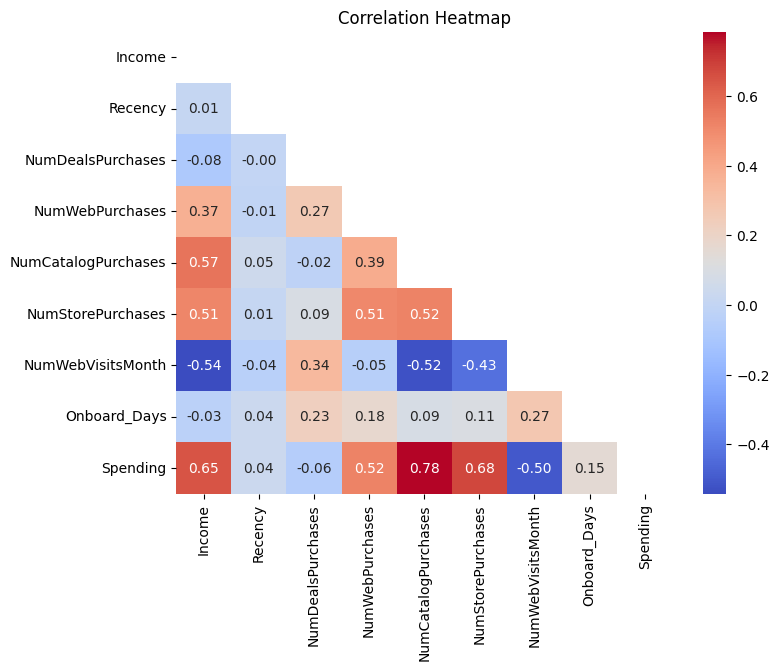

In [23]:
# Examining the correlation
def plot_corr(df):
    plt.figure(figsize=(8, 6))

    corr_matrix = df[numerical_ftrs].corr()
    
    # mask for upper triangle
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, annot=True, mask=mask, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Heatmap")
    plt.show()
    
plot_corr(train_data)

In [24]:
# Function to plot the distribution of numerical features
def dist_plot(df):        
        _, axes = plt.subplots(3, 3, figsize=(8, 6))
        axes = axes.flatten()

        for i, var in enumerate(numerical_ftrs):
                sns.histplot(x=var, ax=axes[i], data=df, kde=True)
        # axes[-1].axis('off')
        # axes[-2].axis('off')
        plt.tight_layout()
        plt.show()

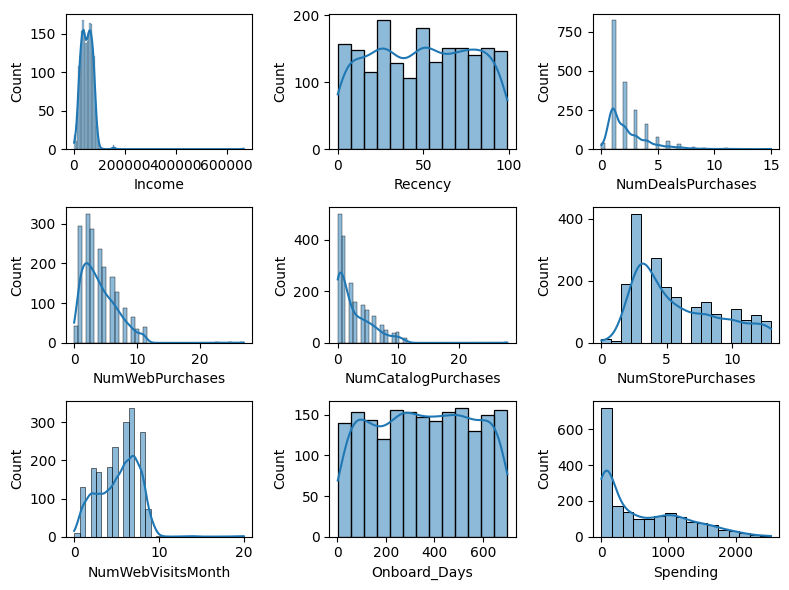

In [25]:
# Check for the distribution of numeric features
dist_plot(train_data)

### Data Cleaning Function

In [26]:
def clean_data(df):
        
    # Conversions into 'datetime' data type
    df['Year_Birth'] = pd.to_datetime(df['Year_Birth'], format='%Y')
    df["Dt_Customer"] = pd.to_datetime(df["Dt_Customer"])

    # get customer age
    # assuming analysis was conducted in 2014
    now = 2014
    df['Age'] = now - df['Year_Birth'].dt.year
    
    # define the bin edges for age groups
    bins = [18, 28, 38, 48, 58, 65, np.inf]

    # define the labels for each age group
    labels = ['18-27', '28-37', '38-47', '48-57', '58-65', '65+']

    # create the age groups column
    df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

    # Calculate the number of days since customer enrolled
    end_fiscal = datetime(2014, 6, 30)
    df['Onboard_Days'] = (end_fiscal - df['Dt_Customer']).dt.days

    # use overall spending
    df['Spending'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + \
                       df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']

    # reduce categories in marital status
    marital_status = {'Divorced': 'Alone', 'Single': 'Alone', 'Married': 'In couple', 'Together': 'In couple', 'Absurd': 'Alone', 'Widow': 'Alone', 'YOLO': 'Alone'}
    df['Marital_Status'] = df['Marital_Status'].replace(marital_status)

    # reduce categories in education
    education_level = {'Basic': 'Undergraduate', '2n Cycle': 'Undergraduate', 'Graduation': 'Postgraduate', 'Master': 'Postgraduate', 'PhD': 'Postgraduate'}
    df['Education'] = df['Education'].replace(education_level)

    # get the total count of children
    df['Children'] = df['Kidhome'] + df['Teenhome']

    # drop redundant features
    redundant_features = ['Year_Birth', 'Dt_Customer', 'Age', 'ID', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Kidhome', 'Teenhome']
    df = df.drop(redundant_features, axis=1)
    
    return df

## Data Normalization

In [27]:
# Numeric features transformation
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('normalize', StandardScaler()),
])

# ColumnTransformer with numeric and categorical features transformers
ct = ColumnTransformer([
    ('num_trans', num_transformer, numerical_ftrs),
    ('cat_trans', SimpleImputer(strategy='most_frequent'), categorical_ftrs)
])

# Create a DataFrame
train_norm = pd.DataFrame(ct.fit_transform(train_data), 
                      columns=numerical_ftrs+categorical_ftrs)

In [28]:
# check for dtype changes
train_norm.dtypes.to_frame().T

,Income,Recency,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Onboard_Days,Spending,Education,Marital_Status,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Age_Group,Children
0,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object,object


In [29]:
# correct for dtypes changes
train_norm[numerical_ftrs] = train_norm[numerical_ftrs].astype('float')
train_norm[categorical_ftrs] = train_norm[categorical_ftrs].astype('str')

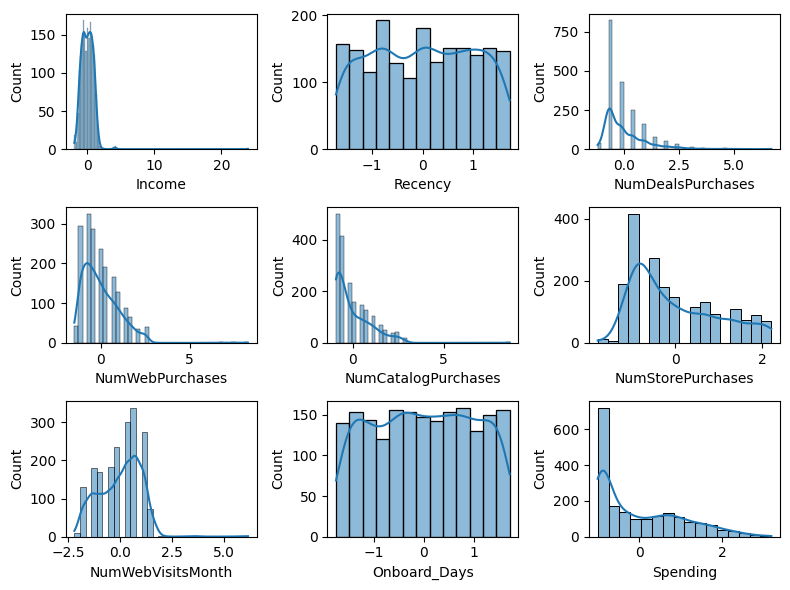

In [30]:
# check distribution of normalized data
dist_plot(train_norm)

### Data Normalization Function

In [31]:
def transform_data(df):
    # feature diversity
    unique_ftrs = df.nunique()

    # get category features
    categorical_ftrs = list(unique_ftrs[(unique_ftrs <= 6)].index)

    # get numerical features
    numerical_ftrs = [col for col in df.columns if col not in categorical_ftrs]

    # normalize the data and handle missing values
    # transformation of numerical variables
    num_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('normalize', StandardScaler()),
    ])


    # transformation of categorical variables
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
    ])


    # apply transformation to the columns
    colTrans = ColumnTransformer([
        ('num_trans', num_transformer, numerical_ftrs),
        ('cat_trans', cat_transformer, categorical_ftrs)
    ])

    # have values as DF
    features = pd.DataFrame(colTrans.fit_transform(df), columns=numerical_ftrs + categorical_ftrs)

    # ensure DF have the right dtypes
    features[categorical_ftrs] = features[categorical_ftrs].astype('str')
    features[numerical_ftrs] = features[numerical_ftrs].astype('float')
    
    return features

## Inspecting Test Data

In [32]:
# import test data
test_data = pd.read_csv('../data/testing_features.csv')
y_test = pd.read_csv('../data/testing_targets.csv')

In [33]:
# # Check class distribution
class_train = y_train.value_counts(normalize=True)
class_test = y_test.value_counts(normalize=True)

pd.concat([class_train, class_test], axis=1, keys=['training_targets', 'validation_targets'])

,training_targets,validation_targets
Response,,
0,0.858193,0.797619
1,0.141807,0.202381


In [34]:
# check missing values
test_data.isnull().sum()[test_data.isnull().sum()>0]

Income    3
dtype: int64

In [35]:
# clean test data
test_clean = clean_data(test_data)

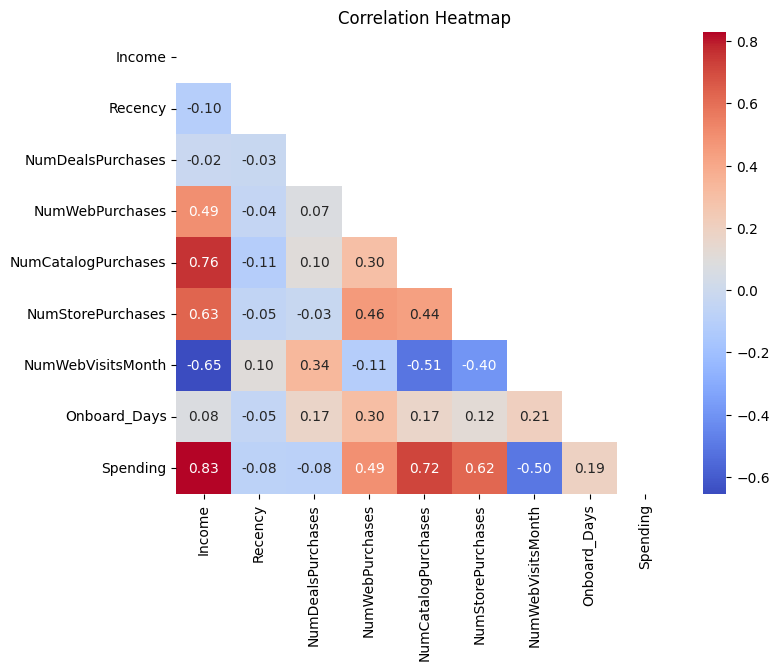

In [36]:
# check correlation
plot_corr(test_clean)

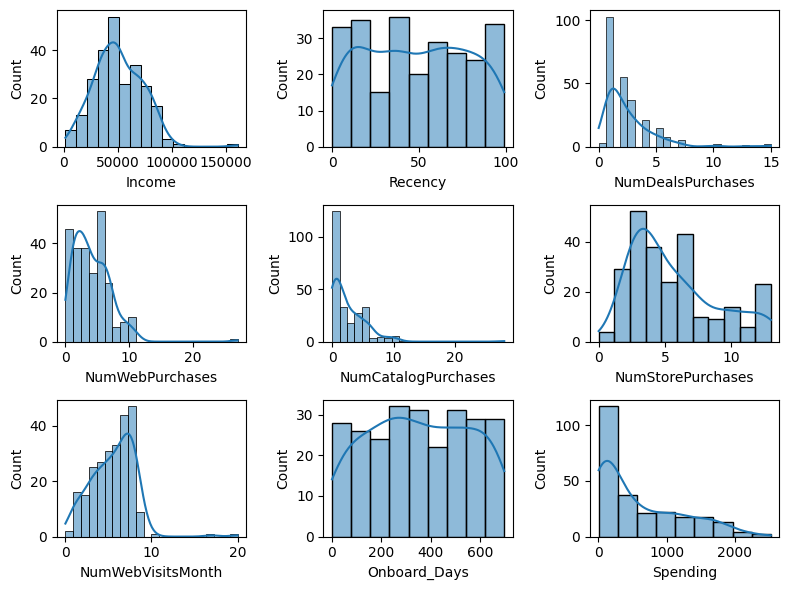

In [37]:
# check distribution
dist_plot(test_clean)

In [38]:
# normalize cleaned data
test_norm = transform_data(test_clean)

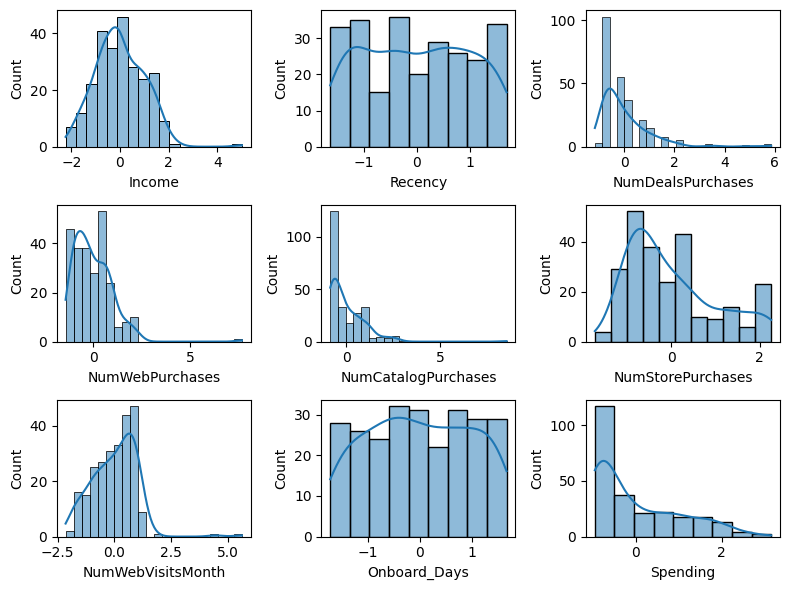

In [39]:
# plot distribution
dist_plot(test_norm)

# Training Models

## Preparing Data

In [40]:
# convert features to dictionary
X_train = train_norm.to_dict(orient='records')
X_test = test_norm.to_dict(orient='records')

# convert target to numpy arrays
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [41]:
# reproducibility seed
SEED = 0

# initialize a dictionary vectorizer
dictVect = DictVectorizer(sparse=False)

## Defining Metrics Function

In [42]:
# function to generate classification metrics
def metrics_output(train_X, test_X, train_y, test_y, clf):
    """Generate relevant classification metrics

    Args:
        train_X: X_train
        test_X: X_test or X_train if testing model performance on training data
        train_y: y_train
        test_y: y_test or y_train if testing model performance on training data
        clf: classifier
    """
    # Fit classifier
    pipeline = make_pipeline(dictVect, clf)
    pipeline.fit(train_X, train_y)
    
    # Get prediction
    y_pred_class = pipeline.predict(test_X)
    
    # Create confusion matrix table
    cols = pd.MultiIndex.from_tuples(
        [('predictions', 0), ('predictions', 1)]
    )
    indx = pd.MultiIndex.from_tuples(
        [('actual', 0), ('actual', 1)]
    )
    cmat = confusion_matrix(test_y, y_pred_class)
    display(pd.DataFrame(cmat, columns=cols, index=indx))
    
    print('-'*50, '\n')

    # Print classification report
    print(classification_report(test_y, y_pred_class))
    
    print('-'*50)

## Training and Fitting Models

In [43]:
# Logistic Regression metrics
lr = LogisticRegression(max_iter=300, random_state=SEED)
metrics_output(X_train, X_test, y_train, y_test, lr)

predictions    
                   0   1
actual 0         196   5
       1          29  22

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       201
           1       0.81      0.43      0.56        51

    accuracy                           0.87       252
   macro avg       0.84      0.70      0.74       252
weighted avg       0.86      0.87      0.85       252

--------------------------------------------------


In [44]:
# Support Vector Classifier metrics
svc = SVC(random_state=SEED, probability=True)
metrics_output(X_train, X_test, y_train, y_test, svc)

predictions    
                   0   1
actual 0         200   1
       1          37  14

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       201
           1       0.93      0.27      0.42        51

    accuracy                           0.85       252
   macro avg       0.89      0.63      0.67       252
weighted avg       0.86      0.85      0.81       252

--------------------------------------------------


In [45]:
# Random Forest Classifier metrics
rfc = RandomForestClassifier(random_state=SEED)
metrics_output(X_train, X_test, y_train, y_test, rfc)

predictions    
                   0   1
actual 0         197   4
       1          27  24

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.88      0.98      0.93       201
           1       0.86      0.47      0.61        51

    accuracy                           0.88       252
   macro avg       0.87      0.73      0.77       252
weighted avg       0.87      0.88      0.86       252

--------------------------------------------------


In [46]:
# # Gradient Boosting Classifier metrics
gbc = GradientBoostingClassifier(random_state=SEED)
metrics_output(X_train, X_test, y_train, y_test, gbc)

predictions    
                   0   1
actual 0         195   6
       1          30  21

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.87      0.97      0.92       201
           1       0.78      0.41      0.54        51

    accuracy                           0.86       252
   macro avg       0.82      0.69      0.73       252
weighted avg       0.85      0.86      0.84       252

--------------------------------------------------


In [47]:
# XGB Classifier metrics
xgbc = XGBClassifier(random_state=SEED)
metrics_output(X_train, X_test, y_train, y_test, xgbc)

predictions    
                   0   1
actual 0         196   5
       1          30  21

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.87      0.98      0.92       201
           1       0.81      0.41      0.55        51

    accuracy                           0.86       252
   macro avg       0.84      0.69      0.73       252
weighted avg       0.86      0.86      0.84       252

--------------------------------------------------


In [48]:
# Decision Tree Classifier metrics
dtc = DecisionTreeClassifier(random_state=SEED)
metrics_output(X_train, X_test, y_train, y_test, dtc)

predictions    
                   0   1
actual 0         178  23
       1          25  26

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.88      0.89      0.88       201
           1       0.53      0.51      0.52        51

    accuracy                           0.81       252
   macro avg       0.70      0.70      0.70       252
weighted avg       0.81      0.81      0.81       252

--------------------------------------------------


In [49]:
# Naive Bayes metrics
gaus = GaussianNB()
metrics_output(X_train, X_test, y_train, y_test, gaus)

predictions    
                   0   1
actual 0         181  20
       1          26  25

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.87      0.90      0.89       201
           1       0.56      0.49      0.52        51

    accuracy                           0.82       252
   macro avg       0.71      0.70      0.70       252
weighted avg       0.81      0.82      0.81       252

--------------------------------------------------


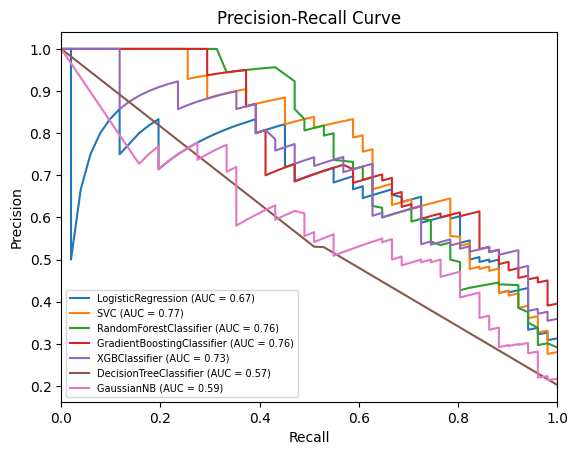

In [50]:
models = [lr, svc, rfc, gbc, xgbc, dtc, gaus]
 
# Train the models and calculate precision-recall values

results = []
for model in models:
    pipeline = make_pipeline(dictVect, model)
    pipeline.fit(X_train, y_train)
    probs = pipeline.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, probs)
    model_name = pipeline.steps[-1][1].__class__.__name__
    results.append((model_name, precision, recall))

# Create a single plot for Precision-Recall curves
fig, ax = plt.subplots()
for name, precision, recall in results:
    auc_score = auc(recall, precision)
    ax.plot(recall, precision, label=f"{name} (AUC = {auc_score:.2f})")

plt.xlabel('Recall')
plt.xlim(0, 1)
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(prop={'size': 7})
plt.show()


# Testing Model on Validation Set

## Preparing Data

In [51]:
# load validation data
val_data = pd.read_csv('../data/validation_features.csv')
y_val = pd.read_csv('../data/validation_targets.csv')

# turn target variable to array
y_val = y_val.values.ravel()

In [52]:
# clean validation data
val_clean = clean_data(val_data)

# transform validation data
val_norm = transform_data(val_clean)

In [53]:
# convert validation features to dictionary
X_val = val_norm.to_dict(orient='records')

## Fitting Models

In [54]:
# Logistic Regression metrics
metrics_output(X_train, X_val, y_train, y_val, lr)

predictions   
                   0  1
actual 0          69  2
       1           6  7

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.92      0.97      0.95        71
           1       0.78      0.54      0.64        13

    accuracy                           0.90        84
   macro avg       0.85      0.76      0.79        84
weighted avg       0.90      0.90      0.90        84

--------------------------------------------------


In [55]:
# Gradient Boosting Classifier metrics
metrics_output(X_train, X_val, y_train, y_val, gbc)

predictions   
                   0  1
actual 0          70  1
       1           6  7

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.92      0.99      0.95        71
           1       0.88      0.54      0.67        13

    accuracy                           0.92        84
   macro avg       0.90      0.76      0.81        84
weighted avg       0.91      0.92      0.91        84

--------------------------------------------------


In [56]:
# SVC metrics
metrics_output(X_train, X_val, y_train, y_val, svc)

predictions   
                   0  1
actual 0          69  2
       1           7  6

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        71
           1       0.75      0.46      0.57        13

    accuracy                           0.89        84
   macro avg       0.83      0.72      0.76        84
weighted avg       0.88      0.89      0.88        84

--------------------------------------------------


In [57]:
# Random Forest Classifier metrics
metrics_output(X_train, X_val, y_train, y_val, rfc)

predictions   
                   0  1
actual 0          70  1
       1           6  7

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.92      0.99      0.95        71
           1       0.88      0.54      0.67        13

    accuracy                           0.92        84
   macro avg       0.90      0.76      0.81        84
weighted avg       0.91      0.92      0.91        84

--------------------------------------------------


In [58]:
# XGBC metrics
metrics_output(X_train, X_val, y_train, y_val, xgbc)

predictions   
                   0  1
actual 0          69  2
       1           7  6

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.91      0.97      0.94        71
           1       0.75      0.46      0.57        13

    accuracy                           0.89        84
   macro avg       0.83      0.72      0.76        84
weighted avg       0.88      0.89      0.88        84

--------------------------------------------------


In [59]:
# Decision Tree Classifier metrics
metrics_output(X_train, X_val, y_train, y_val, dtc)

predictions   
                   0  1
actual 0          65  6
       1           6  7

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.92      0.92      0.92        71
           1       0.54      0.54      0.54        13

    accuracy                           0.86        84
   macro avg       0.73      0.73      0.73        84
weighted avg       0.86      0.86      0.86        84

--------------------------------------------------


In [60]:
# Gausian NB metrics
metrics_output(X_train, X_val, y_train, y_val, gaus)

predictions   
                   0  1
actual 0          65  6
       1           7  6

-------------------------------------------------- 

              precision    recall  f1-score   support

           0       0.90      0.92      0.91        71
           1       0.50      0.46      0.48        13

    accuracy                           0.85        84
   macro avg       0.70      0.69      0.69        84
weighted avg       0.84      0.85      0.84        84

--------------------------------------------------


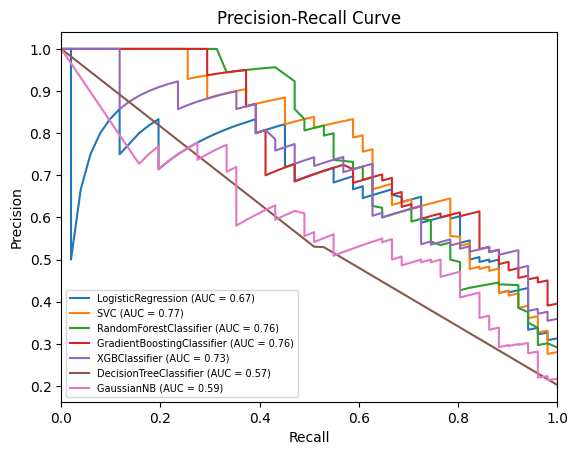

In [61]:
results_val = []
for model in models:
    pipeline = make_pipeline(dictVect, model)
    pipeline.fit(X_train, y_train)
    probs = pipeline.predict_proba(X_val)[:, 1]
    precision, recall, _ = precision_recall_curve(y_val, probs)
    model_name = pipeline.steps[-1][1].__class__.__name__
    results_val.append((model_name, precision, recall))

# Create a single plot for Precision-Recall curves
fig, ax = plt.subplots()
for name, precision, recall in results:
    auc_score = auc(recall, precision)
    ax.plot(recall, precision, label=f"{name} (AUC = {auc_score:.2f})")

plt.xlabel('Recall')
plt.xlim(0, 1)
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(prop={'size': 7})
plt.show()
